<a href="https://colab.research.google.com/github/aurotripathy/RL-Experiments/blob/main/qwen_vl_expt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Ensure you change the runtime to A100 - 80GB

In [7]:
%pip install transformers
%pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 140.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.8.3-cp312-cp312-linux_x86_64.whl size=256040057 sha256=f25da18657a87fc83dc1bfb8b7751b82246e9db355510226b674fd437c34b5fb
  Stored in directory: /root/.cache/pip/wheels/3d/59/46/f282c12c73dd4bb3c2e3fe199f1a0d0f8cec06df0cccfeee27
Successfully built flash-attn


In [2]:
!nvidia-smi

Fri Oct 31 22:05:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   34C    P0             56W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
jason_schema = {
  "$schema": "http://json-schema.org/draft-07/schema#",
  "title": "NutritionFacts",
  "type": "object",
  "properties": {
    "product_name": { "type": ["string", "null"] },
    "brand": { "type": ["string", "null"] },
    "source_url": { "type": "string", "format": "uri" },
    "servings_per_container": { "type": ["number", "string", "null"] },
    "serving_size": {
      "type": "object",
      "properties": {
        "quantity": { "type": ["number", "null"] },
        "unit": { "type": ["string", "null"] },
        "description": { "type": ["string", "null"] }
      },
      "required": ["quantity", "unit"]
    },
    "calories": { "type": ["number", "null"] },
    "macros": {
      "type": "object",
      "properties": {
        "total_fat_g": { "type": ["number", "null"] },
        "total_fat_dv_percent": { "type": ["number", "null"] },
        "saturated_fat_g": { "type": ["number", "null"] },
        "saturated_fat_dv_percent": { "type": ["number", "null"] },
        "trans_fat_g": { "type": ["number", "null", "string"] },
        "cholesterol_mg": { "type": ["number", "null", "string"] },
        "cholesterol_dv_percent": { "type": ["number", "null"] },
        "sodium_mg": { "type": ["number", "null"] },
        "sodium_dv_percent": { "type": ["number", "null"] },
        "total_carbohydrate_g": { "type": ["number", "null"] },
        "total_carbohydrate_dv_percent": { "type": ["number", "null"] },
        "dietary_fiber_g": { "type": ["number", "null", "string"] },
        "dietary_fiber_dv_percent": { "type": ["number", "null"] },
        "total_sugars_g": { "type": ["number", "null"] },
        "added_sugars_g": { "type": ["number", "null"] },
        "added_sugars_dv_percent": { "type": ["number", "null"] },
        "protein_g": { "type": ["number", "null"] }
      },
      "required": ["total_fat_g","saturated_fat_g","trans_fat_g","sodium_mg","total_carbohydrate_g","protein_g"]
    },
    "micronutrients_dv_percent": {
      "type": "object",
      "properties": {
        "vitamin_d": { "type": ["number", "null"] },
        "calcium": { "type": ["number", "null"] },
        "iron": { "type": ["number", "null"] },
        "potassium": { "type": ["number", "null"] }
      }
    },
    "notes": { "type": ["string", "null"] }
  },
  "required": ["source_url", "serving_size", "macros"]
}


In [8]:
# from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import Qwen3VLMoeForConditionalGeneration, AutoProcessor
import torch

model_name = "Qwen/Qwen3-VL-30B-A3B-Instruct"

# default: Load the model on the available device(s)
# model = Qwen3VLMoeForConditionalGeneration.from_pretrained(
#     model_name, dtype="auto", device_map="cuda"
# )


# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
model = Qwen3VLMoeForConditionalGeneration.from_pretrained(
    model_name,
    dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="cuda",
)

Loading checkpoint shards:   0%|          | 0/13 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

In [9]:
import json

instruction = f"Extract all the nutrition information in JSON format according to the following schema:\n{json.dumps(jason_schema, indent=2)}"

processor = AutoProcessor.from_pretrained("Qwen/Qwen3-VL-30B-A3B-Instruct")

# image_link = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
image_link = "https://s7d1.scene7.com/is/image/hersheyprodcloud/0_34000_00246_7_701_24600_073_Item_Back_B?fmt=webp-alpha&hei=908&qlt=75"

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_link,
            },
            {"type": "text", "text": instruction},
        ],
    }
]

# Preparation for inference with the updated messages
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
).to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=1024) # Increased max_new_tokens
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text[0]) # Print the first output

preprocessor_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

```json
{
  "product_name": null,
  "brand": null,
  "source_url": "https://www.smartlabel.org/",
  "servings_per_container": 1,
  "serving_size": {
    "quantity": 1,
    "unit": "package",
    "description": "42g"
  },
  "calories": 210,
  "macros": {
    "total_fat_g": 11,
    "total_fat_dv_percent": 14,
    "saturated_fat_g": 7,
    "saturated_fat_dv_percent": 35,
    "trans_fat_g": 0,
    "cholesterol_mg": "<5",
    "cholesterol_dv_percent": 0,
    "sodium_mg": 20,
    "sodium_dv_percent": 1,
    "total_carbohydrate_g": 28,
    "total_carbohydrate_dv_percent": 10,
    "dietary_fiber_g": "<1",
    "dietary_fiber_dv_percent": 0,
    "total_sugars_g": 23,
    "added_sugars_g": 22,
    "added_sugars_dv_percent": 44,
    "protein_g": 2
  },
  "micronutrients_dv_percent": {
    "vitamin_d": 0,
    "calcium": 4,
    "iron": 6,
    "potassium": 2
  },
  "notes": "CONTAINS: MILK, WHEAT, SOY. MANUFACTURED IN A FACILITY THAT PROCESSES PEANUTS."
}
```


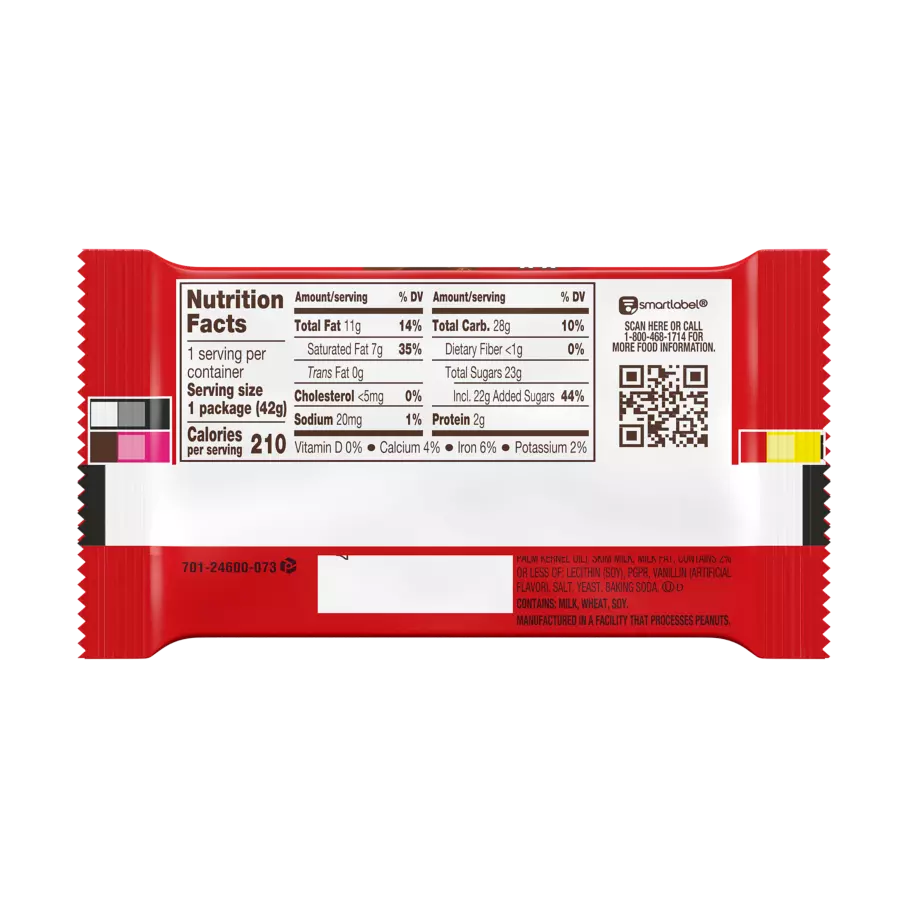

In [10]:
from IPython.display import Image, display
import requests

# Assuming the image is the first item in the first message's content
image_url = messages[0]['content'][0]['image']

# Download the image from the URL
response = requests.get(image_url)
with open("temp_image.jpeg", "wb") as f:
    f.write(response.content)

# Display the image
display(Image(filename="temp_image.jpeg"))